# Program to Implement the Pipeline of Proposed Method

## Importing Libraries and dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import argparse
from skimage.segmentation import mark_boundaries
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from skimage.measure import compare_ssim
from numpy.linalg import norm
import os

from superpixel import superpixel, centroid, highway_pixel,coherence_estimator, oneD_regionProp, centroid_single
from highwayDecomp import decomposition_highway, decomposition_super
from utils import readFloatComplex, readShortComplex, readFloat

# Initializing variables
WIDTH = 300
PATCH_SIZE = [300,300]  # patch size
STRIDE = 150     # Stride
NUM_FILES = 4

# Number of clusters in Stage II Super Pixeling 
k=75

# Defining path for output visuals
path = r"outputs\pipeline"

# Defining path for input dataset
base = r"data2"
filelist = os.listdir(base)

## Function to calculate Stage II Super pixels

In [2]:
def calculate_highway(superpixel,input,k,slc1,slc2):
    """
    Pipeline to calculate highway pixels from input super pixels
    
    Args: 
    
    superpixel: Stage I super pixels
    input: 4 channels input data
    k: Number of clusters for Stage II super pixeling
    slc1: First SAR Image
    slc2: Second SAR Image
    
    Returns: 
    
    coh: Coherence decomposed to pixel level
    new_input: Labels decomposed to pixel level
    """
    # Finding the Cluster centroids along each channel and stacked
    centroids_super,a1_list,a2_list,real_list,imag_list,coordinates_super = centroid(superpixel,input)

    # Stacking the input for Stage II Super pixeling
    input_super = np.dstack((a1_list,a2_list,real_list,imag_list))
    
    # Stage II super pixeling using K-means
    kmeans = KMeans(n_clusters=k, random_state=0).fit(input_super.reshape(-1,4))
    highway = kmeans.labels_

    # Passing the highway cluster labels to pixel-level
    new_input = highway_pixel(input,superpixel,highway)
    
    # Finding the centroid of highway pixel and each channel separately
    centroids_highway,a1_list,a2_list,real_list,imag_list, coordinates_high = centroid_single(highway ,input_super)

    # Coherence Estimation using Maximum Liklihood Estimat
    highway_coh = coherence_estimator(new_input,slc1,slc2)

    # Decomposing highway pixel to superpixel
    decom_super_coh = decomposition_highway(centroids_highway, highway,highway_coh,coordinates_high,input_super)
    
    # Decomposing super pixel to pixel-level
    coh = decomposition_super(centroids_super,superpixel,decom_super_coh,coordinates_super,input)
    
    return coh, new_input

## Function to calculate evaluation metrics

In [3]:
def calculate_metrics(coh_3vg,coh):
    """
    Function to calculate MSE and SSIM
    
    Inputs: 
    coh_3vg: Ground truth of coherence
    coh: Estimated coherence
    
    Returns: 
    mses: Mean Squared error
    rmse: Root mean-squared error
    ssim: Structural Similarity Index
    """
    mses=mean_squared_error(coh_3vg,coh)
    print("MSE", mses)
    print("RMSE",np.sqrt(mses))
    (score, diff) = compare_ssim(np.array(coh_3vg), np.array(coh), full=True)
    diff = (diff * 255).astype("uint8")
    print("SSIM: {}".format(score))
    
    return mses,np.sqrt(mses),score

## Function to display visual comparison results

In [4]:
def display_result(coh_3vg,coh):
    """
    Function to display visual comparison

    Inputs: 
    coh_3vg: Ground truth of coherence
    coh: Estimated coherence
    
    Returns:
    matplotlib object for displaying
    
    """
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(coh_3vg)
    ax[0].set_title("Ground Truth")
    ax[1].imshow(coh, vmin=np.array(coh).min(), vmax = np.array(coh).max())
    ax[1].set_title("Estimated Level Coh")
    return plt

## Function to implement Boxcar (sliding window)

In [5]:
def sliding_window(input, slc1,slc2,stepSize, windowSize):
    """
    Function to perform boxcar function on the input
    
    Args: 
    
    input: 4 channel input data on which boxcar needs to be performed
    slc1: First SAR Image
    slc2: Second SAR Image
    stepSize: Stride requuired for the sliding window
    windorSize: Size of sliding window
    
    Returns: 
    coh : Coherence estimate using sliding window
    """
    
    coh = np.zeros((300,300))
    
    # slide a window across the image
    for y in range(0, 300, stepSize):
        for x in range(0, 300, stepSize):
            
            # yield the current window
            window = input[y:y + windowSize[1], x:x + windowSize[0],:]
            
            # Getting the window on SAR Image 1 and 2
            z1 = slc1[y:y + windowSize[1], x:x + windowSize[0]]
            z2 = slc2[y:y + windowSize[1], x:x + windowSize[0]]

            # Coherence estimate using maximum liklihood estimator
            delta = np.abs(np.sum(z1*np.conj(z2))/np.sqrt(np.sum(np.abs(z1)**2.)*np.sum(np.abs(z2)**2.)))
            
            # Assigning pixel-wise coherence
            coh[x,y] = delta

    return np.transpose(coh)

## Function to implement the pipeline of the proposed application (For one sample input)

In [6]:
def pipeline(filelist, method):
    """
    Function to read the files, implement the pipeline
    
    Inputs: 
    
    filelist: list of input files
    method: Method for Stage I Super pixeling
    """
    mse_list, rmse_list, ssim_list = [],[],[]
    mse_list_sliding, rmse_list_sliding, ssim_list_sliding = [],[],[]
    coh_list, coh3vg_list, coh_list_sliding = [],[],[]
    for i in range(0,int(len(filelist)/NUM_FILES)):
        
        # Loading first dataset
        
#         IFG_PATH = os.path.join(base,str(i)+"slc1_"+str(i)+"slc2.noisy")
#         COH_PATH = os.path.join(base,str(i)+"slc1_"+str(i)+"slc2.filt.coh")
#         SLC1_PATH = os.path.join(base,str(i)+"slc1.rslc")
#         SLC2_PATH = os.path.join(base,str(i)+"slc2.rslc")

#         ifg = readFloatComplex(IFG_PATH, WIDTH)
#         coh_3vg = readFloat(COH_PATH, WIDTH)
#         slc1 = readFloatComplex(SLC1_PATH, WIDTH)
#         slc2 = readFloatComplex(SLC2_PATH, WIDTH)

        # Loading second dataset
        ifg = np.load(os.path.join(base,str(i)+".ifg.npy"))
        coh_3vg = np.load(os.path.join(base,str(i)+".coh.npy"))
        slc1 = np.load(os.path.join(base,str(i)+".slc1.npy"))
        slc2 = np.load(os.path.join(base,str(i)+".slc2.npy"))
        

        # Creating the 4-channel input 

        # Dim-0
        amp_slc1 = np.abs(slc1)

        # Dim-1
        amp_slc2 = np.abs(slc2)

        # Phase of Ifg
        phase_ifg = np.angle(ifg)

        # Force amp to one
        phase_bar_ifg = 1*np.exp(1j*phase_ifg)

        # Dim-2
        real_ifg_phase = np.real(phase_bar_ifg)
        # Dim-3
        imag_ifg_phase = np.imag(phase_bar_ifg)

        # Stacking each dimension in each channel
        input = np.dstack((amp_slc1,amp_slc2,real_ifg_phase,imag_ifg_phase))

        width = len(input)
        L,H = PATCH_SIZE[0],PATCH_SIZE[1]

        count=0
        switch2= 0
        
        # Sliding through the window
        for y in range(0, width, STRIDE):
            
            if (y+H > width):
                y = width - H
                switch2=1
                
            switch1=0
            for x in range(0, width, STRIDE):
                
                # Adjusting x and y values for the last patch horizontally and vertically
                if (x+L > width):
                    x = width - L
                    switch1 = 1
                print("X values", x,x+L)
                print("Y values",y, y+H)

                # yield the current window
                window = input[y:y + H, x:x + L,:]
                
                # Getting the window on SAR Image 1 and 2
                z1 = slc1[y:y + H, x:x + L]
                z2 = slc2[y:y + H, x:x + L]
                coh_window = coh_3vg[y:y + H, x:x + L]

                # Stage I of Super pixeling
                superpixel_fz,superpixel_slic=superpixel(window)

                if method == 'slic':
                    super = superpixel_slic
                else:
                    super = superpixel_fz
                    
                # Calculating highway pixels and coherence
                coh, highway_labels = calculate_highway(super,window, k,z1,z2)

                # Calculating evaluation metrics
                print("Proposed Methods Results\n")
                mse,rmse,ssim = calculate_metrics(coh_window, coh)

                # Appending coherence values of all inputs to a list for saving
                coh3vg_list.append(coh_window)
                coh_list.append(coh)

                # Appending metrics values of all inputs to a list
                mse_list.append(mse)
                rmse_list.append(rmse)
                ssim_list.append(ssim)
            
                # Displaying the results
                plt = display_result(coh_window, coh)
                plt.savefig(os.path.join(path,str(i)+r"_patch"+str(count)+"_Result"))
                plt.show()
                
                # Sliding window 7x7
                
                # Padding the input with zeros for sliding window
                data = np.pad(window, ((3,3), (3,3), (0, 0)), 'constant')
                
                # Padding the SAR images with zeros for sliding window
                s1 = np.pad(z1, ((3,3), (3,3)), 'constant')
                s2 = np.pad(z2, ((3,3), (3,3)), 'constant')
                
                # Calculating coherence using sliding window of size 7x7
                coh_sliding = sliding_window(data,s1,s2,1,[7,7])
                
                # Appending coherence values sliding window to a list for saving
                coh_list_sliding.append(coh_sliding)
                
                # Appending metrics values of sliding window to a list
                print("Boxcar Results\n")
                mse_sliding,rmse_sliding,ssim_sliding = calculate_metrics(coh_window, coh_sliding)
                
                # Appending metrics values of sliding window to a list
                mse_list_sliding.append(mse_sliding)
                rmse_list_sliding.append(rmse_sliding)
                ssim_list_sliding.append(ssim_sliding)

                # Displaying the results
                plt = display_result(coh_window, coh_sliding)
                plt.savefig(os.path.join(path,"Sliding"+str(i)+r"_patch"+str(count)+"_Result"))
                plt.show()
                  
                count += 1
                
                
                if (width==H):
                    break
                if(switch1 ==1):
                    break
            if(switch2==1):
                break
        print("Input number",i)
        


    return coh_list,coh3vg_list, coh_list_sliding, mse_list,rmse_list,ssim_list,mse_list_sliding,rmse_list_sliding,ssim_list_sliding,i


## Main Function

X values 0 300
Y values 0 300


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2344
SLIC number of Super Pixels: 2481
Proposed Methods Results

MSE 0.016880807272436005
RMSE 0.12992616084698264
SSIM: 0.6683090287201299


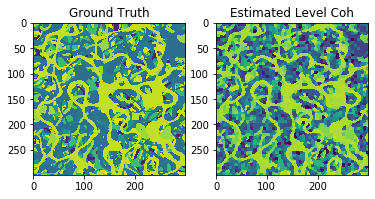

Boxcar Results

MSE 0.03328053664856353
RMSE 0.182429538859702
SSIM: 0.45591823789592373


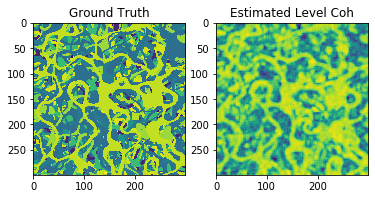

X values 150 450
Y values 0 300


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2309
SLIC number of Super Pixels: 2481
Proposed Methods Results

MSE 0.017829987842574245
RMSE 0.13352897753886325
SSIM: 0.6571786201214941


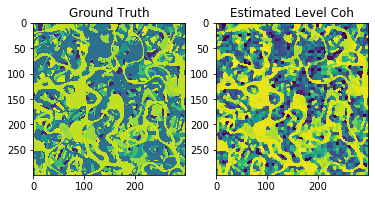

Boxcar Results

MSE 0.034061312441708076
RMSE 0.18455707096101215
SSIM: 0.4512839362572429


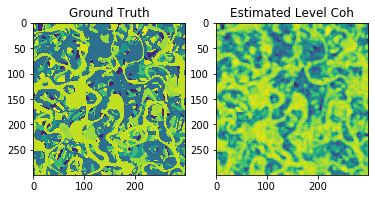

X values 300 600
Y values 0 300


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2310
SLIC number of Super Pixels: 2484
Proposed Methods Results

MSE 0.017693743026915888
RMSE 0.13301782973314474
SSIM: 0.6632675648312261


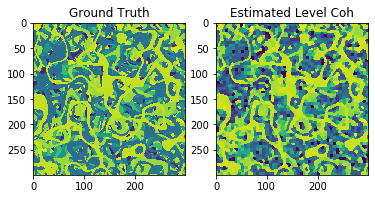

Boxcar Results

MSE 0.03302334078611401
RMSE 0.18172325328948416
SSIM: 0.4611453042664033


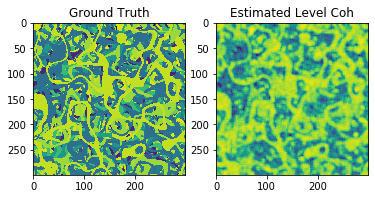

X values 450 750
Y values 0 300


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2359
SLIC number of Super Pixels: 2479
Proposed Methods Results

MSE 0.016887057975048848
RMSE 0.12995021344749244
SSIM: 0.6712957300313838


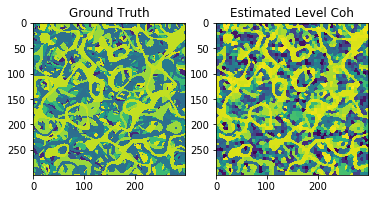

Boxcar Results

MSE 0.0318809147202045
RMSE 0.17855227447502456
SSIM: 0.4694120178434417


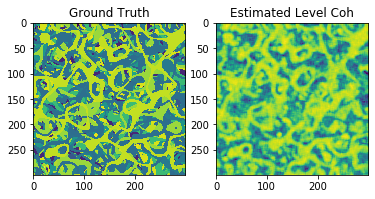

X values 600 900
Y values 0 300


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2410
SLIC number of Super Pixels: 2485
Proposed Methods Results

MSE 0.017000963298923415
RMSE 0.13038774213446375
SSIM: 0.6568645442782779


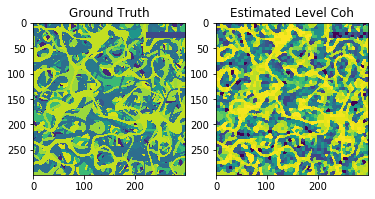

Boxcar Results

MSE 0.031059640855244316
RMSE 0.17623745588053727
SSIM: 0.4624338046008143


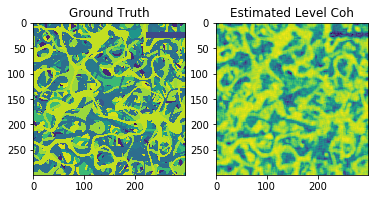

X values 700 1000
Y values 0 300


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2414
SLIC number of Super Pixels: 2488
Proposed Methods Results

MSE 0.01782427873885305
RMSE 0.1335075980566389
SSIM: 0.6583439593124171


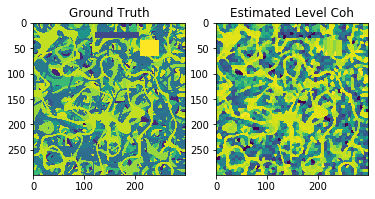

Boxcar Results

MSE 0.03360628208378165
RMSE 0.18332016278571664
SSIM: 0.44583553396998654


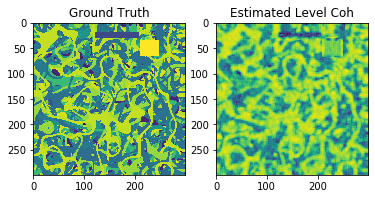

X values 0 300
Y values 150 450


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2356
SLIC number of Super Pixels: 2485
Proposed Methods Results

MSE 0.016648064107347177
RMSE 0.12902737735592076
SSIM: 0.6733399723558713


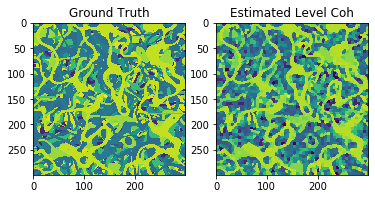

Boxcar Results

MSE 0.03275992256182228
RMSE 0.18099702362697095
SSIM: 0.46030242255428067


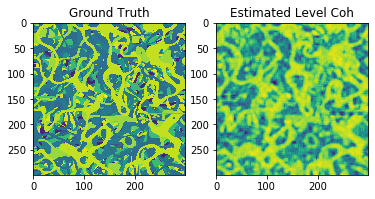

X values 150 450
Y values 150 450


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2338
SLIC number of Super Pixels: 2484
Proposed Methods Results

MSE 0.01757721060935509
RMSE 0.13257907304456118
SSIM: 0.6580358474936544


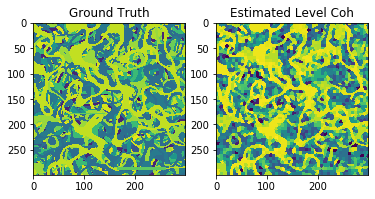

Boxcar Results

MSE 0.034086404176896345
RMSE 0.18462503670113745
SSIM: 0.4460636583259966


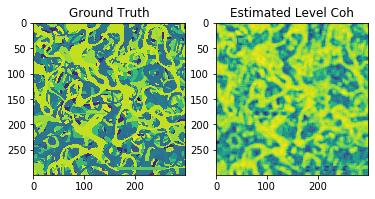

X values 300 600
Y values 150 450


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2367
SLIC number of Super Pixels: 2486
Proposed Methods Results

MSE 0.016848506267733206
RMSE 0.12980179608824066
SSIM: 0.6657051907720906


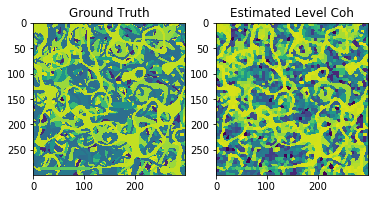

Boxcar Results

MSE 0.032652842387682506
RMSE 0.18070097506013216
SSIM: 0.455252192322238


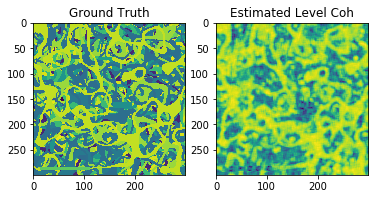

X values 450 750
Y values 150 450


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2407
SLIC number of Super Pixels: 2485
Proposed Methods Results

MSE 0.016785150535465625
RMSE 0.1295575182514146
SSIM: 0.6791088463858922


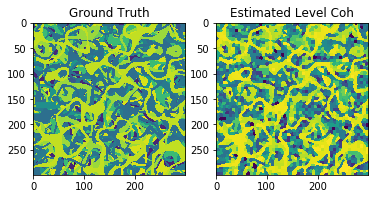

Boxcar Results

MSE 0.03274243949768048
RMSE 0.180948720630129
SSIM: 0.4690460699392969


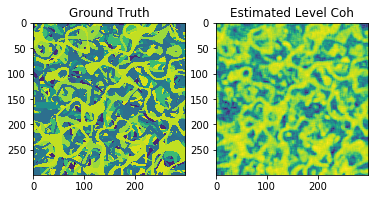

X values 600 900
Y values 150 450


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2399
SLIC number of Super Pixels: 2486
Proposed Methods Results

MSE 0.01634646753957817
RMSE 0.12785330476596282
SSIM: 0.6756700403870086


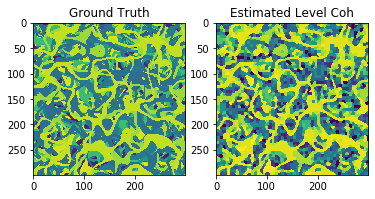

Boxcar Results

MSE 0.031511653181304465
RMSE 0.17751521957653227
SSIM: 0.4701075048619585


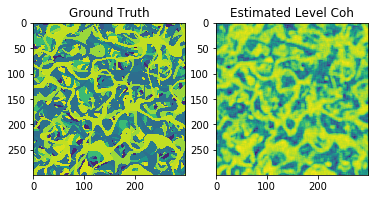

X values 700 1000
Y values 150 450


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2349
SLIC number of Super Pixels: 2488
Proposed Methods Results

MSE 0.016203268984353734
RMSE 0.12729206174916696
SSIM: 0.6774688352166951


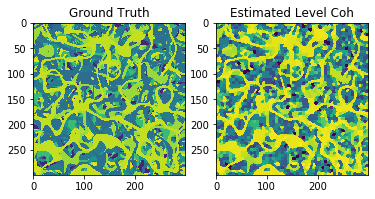

Boxcar Results

MSE 0.031489817572018776
RMSE 0.17745370543332922
SSIM: 0.4624296270818527


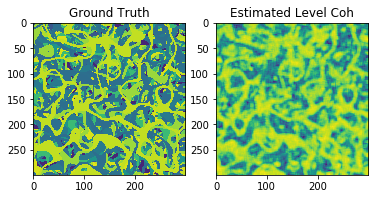

X values 0 300
Y values 300 600


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2413
SLIC number of Super Pixels: 2483
Proposed Methods Results

MSE 0.01707904543045303
RMSE 0.13068682194641137
SSIM: 0.6650727924124901


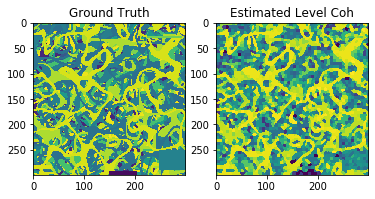

Boxcar Results

MSE 0.03307233470895149
RMSE 0.1818580069970841
SSIM: 0.4539571613970061


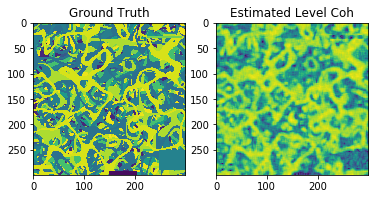

X values 150 450
Y values 300 600


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2422
SLIC number of Super Pixels: 2483
Proposed Methods Results

MSE 0.016326887154383022
RMSE 0.1277767081841719
SSIM: 0.6595883398649519


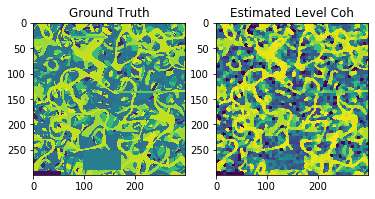

Boxcar Results

MSE 0.03207960861640504
RMSE 0.1791078128290473
SSIM: 0.4491312765833603


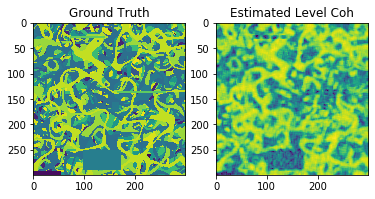

X values 300 600
Y values 300 600


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2402
SLIC number of Super Pixels: 2488
Proposed Methods Results

MSE 0.01600638392795119
RMSE 0.12651633858103542
SSIM: 0.6672908894691036


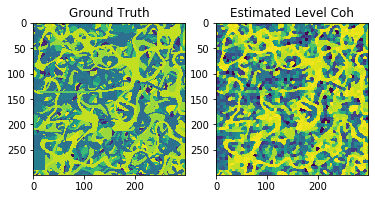

Boxcar Results

MSE 0.03160978175837088
RMSE 0.17779139956243914
SSIM: 0.45310926302789717


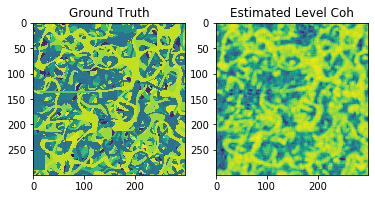

X values 450 750
Y values 300 600


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2412
SLIC number of Super Pixels: 2485
Proposed Methods Results

MSE 0.0169323294830826
RMSE 0.13012428475531615
SSIM: 0.6760334908271332


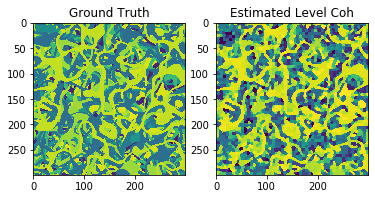

Boxcar Results

MSE 0.03375230263095702
RMSE 0.1837179975695278
SSIM: 0.4626459871498672


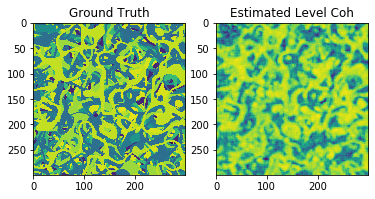

X values 600 900
Y values 300 600


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2391
SLIC number of Super Pixels: 2482
Proposed Methods Results

MSE 0.017028903640413855
RMSE 0.13049484143219553
SSIM: 0.6794987250102061


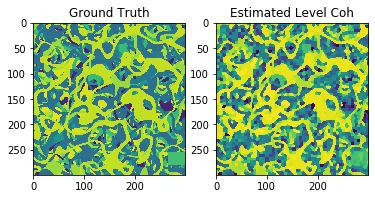

Boxcar Results

MSE 0.03351191707834038
RMSE 0.1830626042596914
SSIM: 0.4724225851818862


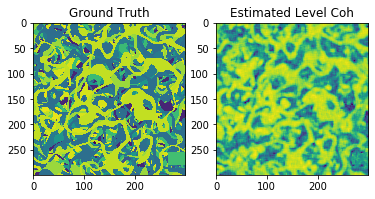

X values 700 1000
Y values 300 600


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2374
SLIC number of Super Pixels: 2483
Proposed Methods Results

MSE 0.016201214757923646
RMSE 0.12728399254393163
SSIM: 0.6841230838649538


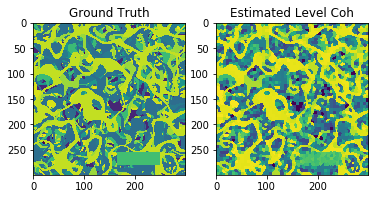

Boxcar Results

MSE 0.03211859405569679
RMSE 0.17921661210863457
SSIM: 0.46924473419162904


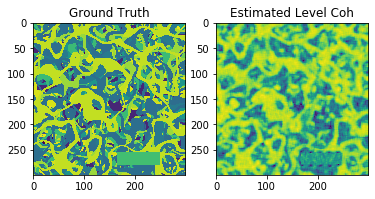

X values 0 300
Y values 450 750


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2388
SLIC number of Super Pixels: 2484
Proposed Methods Results

MSE 0.017759468679193344
RMSE 0.1332646565267526
SSIM: 0.6574195644764156


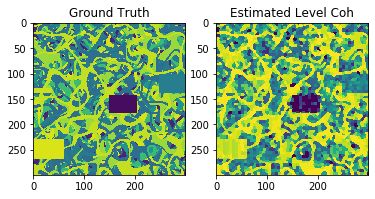

Boxcar Results

MSE 0.034376839929733796
RMSE 0.18540992403249024
SSIM: 0.4559419333180847


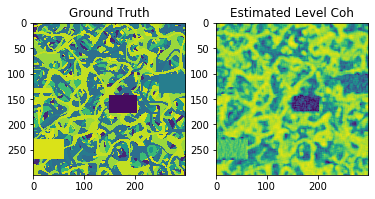

X values 150 450
Y values 450 750


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2372
SLIC number of Super Pixels: 2487
Proposed Methods Results

MSE 0.01647270650862605
RMSE 0.1283460420450356
SSIM: 0.665222024072242


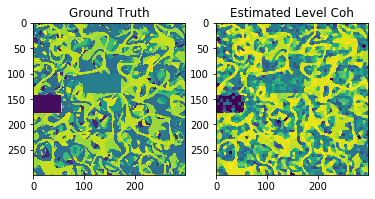

Boxcar Results

MSE 0.0315248143715709
RMSE 0.17755228630341796
SSIM: 0.45907089745494106


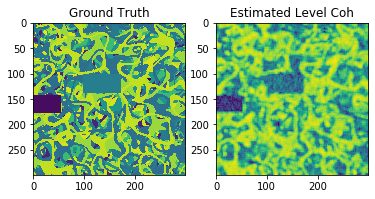

X values 300 600
Y values 450 750


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2344
SLIC number of Super Pixels: 2487
Proposed Methods Results

MSE 0.016332111441126403
RMSE 0.12779714958138308
SSIM: 0.6567023093052715


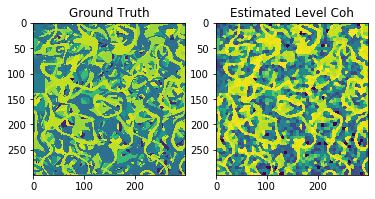

Boxcar Results

MSE 0.030307635334568418
RMSE 0.17409088239930434
SSIM: 0.45714160563901113


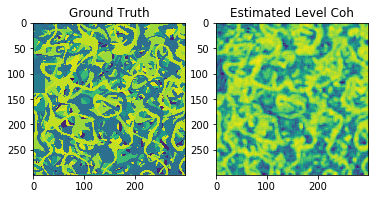

X values 450 750
Y values 450 750


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2386
SLIC number of Super Pixels: 2484
Proposed Methods Results

MSE 0.017082587931523587
RMSE 0.13070037464186393
SSIM: 0.6659974645833133


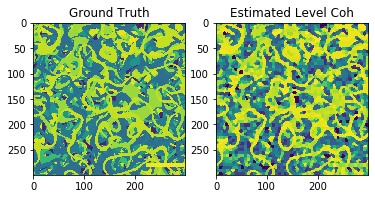

Boxcar Results

MSE 0.03266077240933613
RMSE 0.1807229161156275
SSIM: 0.45756253677090286


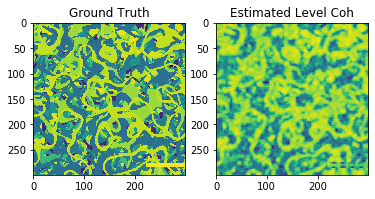

X values 600 900
Y values 450 750


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2413
SLIC number of Super Pixels: 2482
Proposed Methods Results

MSE 0.01713174491375479
RMSE 0.13088829173671263
SSIM: 0.6771958236153439


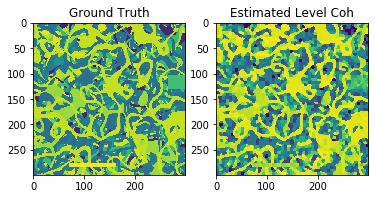

Boxcar Results

MSE 0.03349545558183012
RMSE 0.18301763735178672
SSIM: 0.46651484380172437


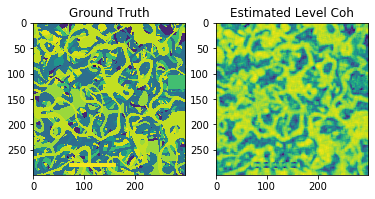

X values 700 1000
Y values 450 750


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2403
SLIC number of Super Pixels: 2487
Proposed Methods Results

MSE 0.01781810689214226
RMSE 0.13348448184018344
SSIM: 0.6674406914727798


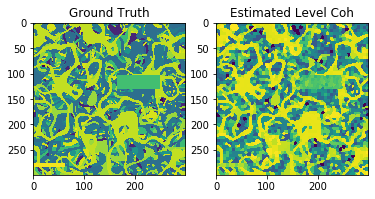

Boxcar Results

MSE 0.03367939310310491
RMSE 0.1835194624640801
SSIM: 0.45461743071530625


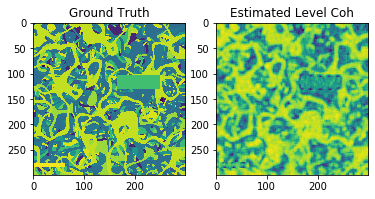

X values 0 300
Y values 600 900


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2342
SLIC number of Super Pixels: 2486
Proposed Methods Results

MSE 0.017385656344966915
RMSE 0.13185467888917296
SSIM: 0.6658903610666078


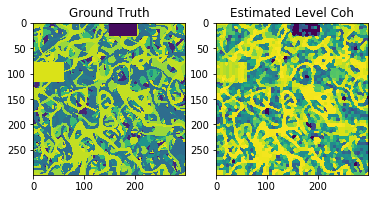

Boxcar Results

MSE 0.03474291900395307
RMSE 0.18639452514479354
SSIM: 0.455606949262247


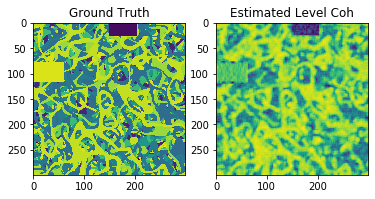

X values 150 450
Y values 600 900


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2359
SLIC number of Super Pixels: 2488
Proposed Methods Results

MSE 0.018015681608124598
RMSE 0.13422250782981443
SSIM: 0.6469528657838436


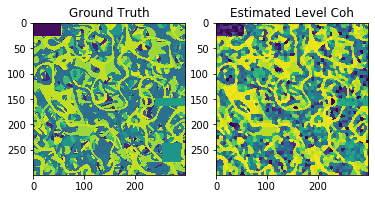

Boxcar Results

MSE 0.0332918048841867
RMSE 0.18246042004825785
SSIM: 0.4450132203975774


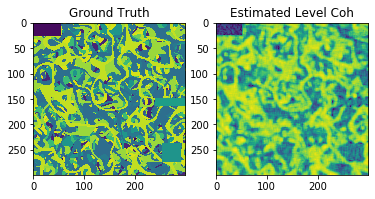

X values 300 600
Y values 600 900


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2343
SLIC number of Super Pixels: 2487
Proposed Methods Results

MSE 0.017285429937553918
RMSE 0.13147406564624797
SSIM: 0.6483140663506286


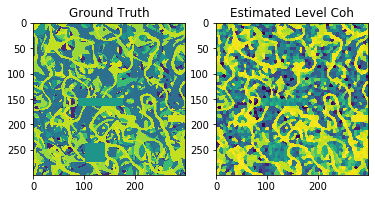

Boxcar Results

MSE 0.03157056646726312
RMSE 0.17768108078032147
SSIM: 0.44785321447137366


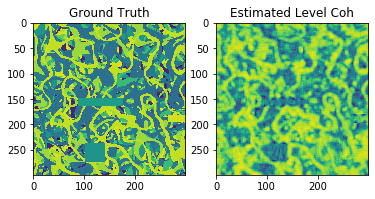

X values 450 750
Y values 600 900


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2371
SLIC number of Super Pixels: 2485
Proposed Methods Results

MSE 0.01708498701634621
RMSE 0.13070955212357743
SSIM: 0.6596928864376381


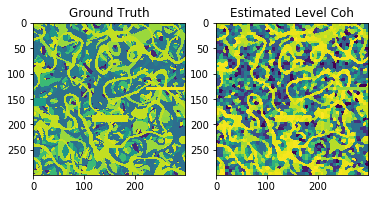

Boxcar Results

MSE 0.03240815892520059
RMSE 0.1800226622545078
SSIM: 0.4511606602049858


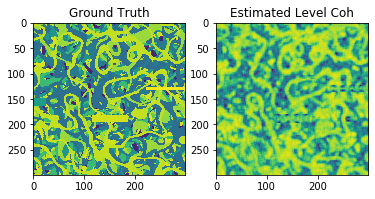

X values 600 900
Y values 600 900


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2399
SLIC number of Super Pixels: 2483
Proposed Methods Results

MSE 0.017755476954294486
RMSE 0.13324967900259455
SSIM: 0.6657809434372384


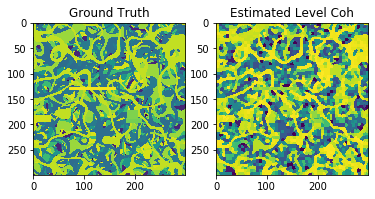

Boxcar Results

MSE 0.03362645647185257
RMSE 0.1833751795414324
SSIM: 0.4549704702531277


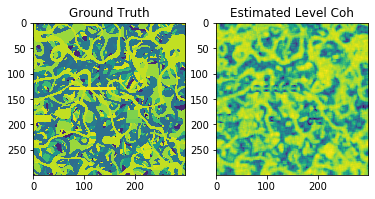

X values 700 1000
Y values 600 900


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2344
SLIC number of Super Pixels: 2488
Proposed Methods Results

MSE 0.01782739020458193
RMSE 0.13351925031463413
SSIM: 0.6630317679910616


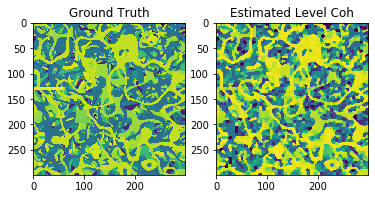

Boxcar Results

MSE 0.033175403235513774
RMSE 0.1821411629355478
SSIM: 0.45833105610362657


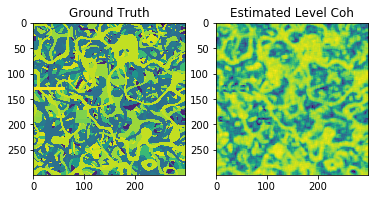

X values 0 300
Y values 700 1000


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2351
SLIC number of Super Pixels: 2486
Proposed Methods Results

MSE 0.017032056128011216
RMSE 0.13050691984722962
SSIM: 0.6726617996803868


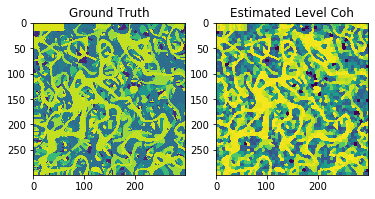

Boxcar Results

MSE 0.033262180165891074
RMSE 0.1823792207623749
SSIM: 0.4596327848123712


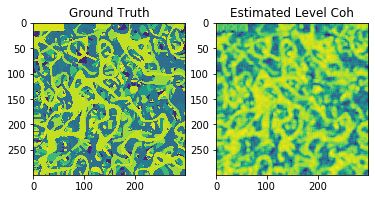

X values 150 450
Y values 700 1000


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2385
SLIC number of Super Pixels: 2489
Proposed Methods Results

MSE 0.018204182734046257
RMSE 0.134922876985507
SSIM: 0.6461269007265851


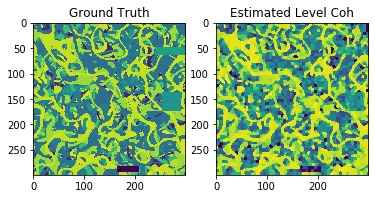

Boxcar Results

MSE 0.033412688384815085
RMSE 0.1827913794050887
SSIM: 0.4431894188334994


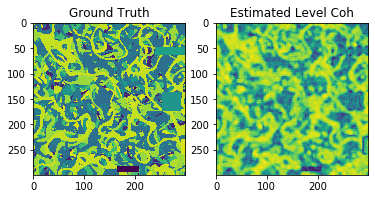

X values 300 600
Y values 700 1000


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2379
SLIC number of Super Pixels: 2486
Proposed Methods Results

MSE 0.017826619219101076
RMSE 0.13351636311366888
SSIM: 0.6441704144151347


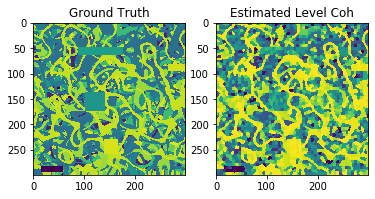

Boxcar Results

MSE 0.03312231871309116
RMSE 0.18199538102130824
SSIM: 0.4404426988383161


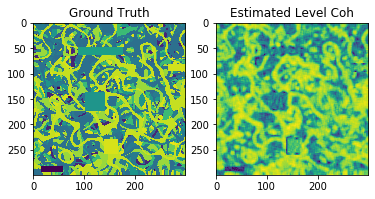

X values 450 750
Y values 700 1000


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2377
SLIC number of Super Pixels: 2481
Proposed Methods Results

MSE 0.018275320664786352
RMSE 0.13518624436231058
SSIM: 0.649618897345071


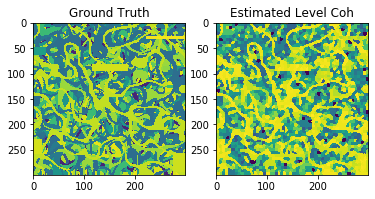

Boxcar Results

MSE 0.03349896040809124
RMSE 0.18302721220652202
SSIM: 0.4408116084398641


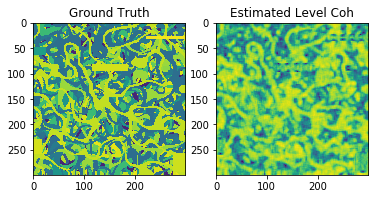

X values 600 900
Y values 700 1000


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2404
SLIC number of Super Pixels: 2486
Proposed Methods Results

MSE 0.01776693411414632
RMSE 0.1332926633920499
SSIM: 0.6629281744841953


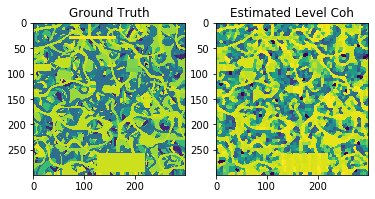

Boxcar Results

MSE 0.035865830183223556
RMSE 0.18938276105079774
SSIM: 0.44900522787668334


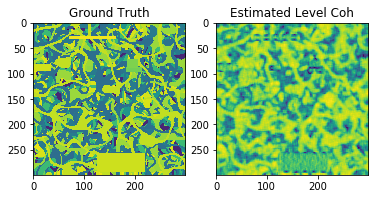

X values 700 1000
Y values 700 1000


C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 2370
SLIC number of Super Pixels: 2483
Proposed Methods Results

MSE 0.01729913902272821
RMSE 0.13152619139444513
SSIM: 0.6750041190461092


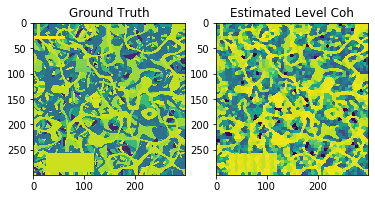

Boxcar Results

MSE 0.03443163382729118
RMSE 0.1855576293966141
SSIM: 0.46207397552884305


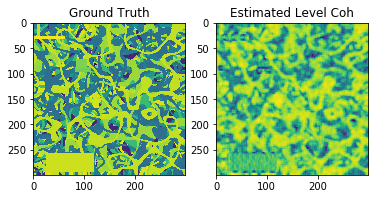

Input number 0


In [7]:
if __name__ == '__main__':   
    """
    Implementing the pipeline
    """

    coh_list,coh3vg_list, coh_list_sliding, mse_list,rmse_list,ssim_list,mse_list_sliding,rmse_list_sliding,ssim_list_sliding,i = pipeline(filelist, 'slic')    

In [8]:
print("Average MSE",np.mean(mse_list))
print("Average RMSE",np.mean(rmse_list))
print("Average SSIM",np.mean(ssim_list))


print("Sliding Window")

print("Average MSE",np.mean(mse_list_sliding))
print("Average RMSE",np.mean(rmse_list_sliding))
print("Average SSIM",np.mean(ssim_list_sliding))

Average MSE 0.017179329747440155
Average RMSE 0.13104929527025275
Average SSIM 0.6646207382123568
Sliding Window
Average MSE 0.03296537436561833
Average RMSE 0.1815371276061224
Average SSIM 0.45635227361593234


In [11]:
# Saving all the coherence files

np.save('coh_slic_'+str(i), coh_list)
np.save('coh3vg_slic_'+str(i),coh3vg_list)
np.save('coh_sliding_slic_'+str(i),coh_list_sliding)


# End of Program